<a href="https://colab.research.google.com/github/lusamdebonfils/Machine-Learning/blob/main/610096_final_project_CS582.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description : # IEE Fraud Detection Final Project for Samuel Machine Learning
This Project is based off a previous Kaggle Competition to detect Fraudulent Transaction.

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

The challenge is to build a model that can predict unseen clients (not unseen time). So the idea is that we are not predicting fraudulent transactions using machine learning, we are predicting fraudulent clients (credit cards).

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information

###Importing Dependencies

In [1]:
import pandas as pd
import numpy as np

#from google.colab import files
#uploaded = files.upload()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

### Loading Data

In [3]:
%%time
train_id = pd.read_csv("train_identity.csv")
train_tr = pd.read_csv("train_transaction.csv")

CPU times: user 19.7 s, sys: 5.28 s, total: 25 s
Wall time: 25.3 s


Displaying insights in the data

In [4]:
train_id.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [ ]:
train_tr.head(10)

In [6]:
train_id.shape

(144233, 41)

In [5]:
train_tr.shape

(590540, 394)

### Merge the data

In [7]:
train = pd.merge(
    train_tr,
    train_id,
    how="left",
    on="TransactionID",
    left_index=True,
    right_index=True,
)

In [8]:
train_id.shape

(144233, 41)

In [21]:
train.shape

(590540, 434)

In [22]:
len(train[train["isFraud"]==1])/len(train)*100

3.4990009144173126

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

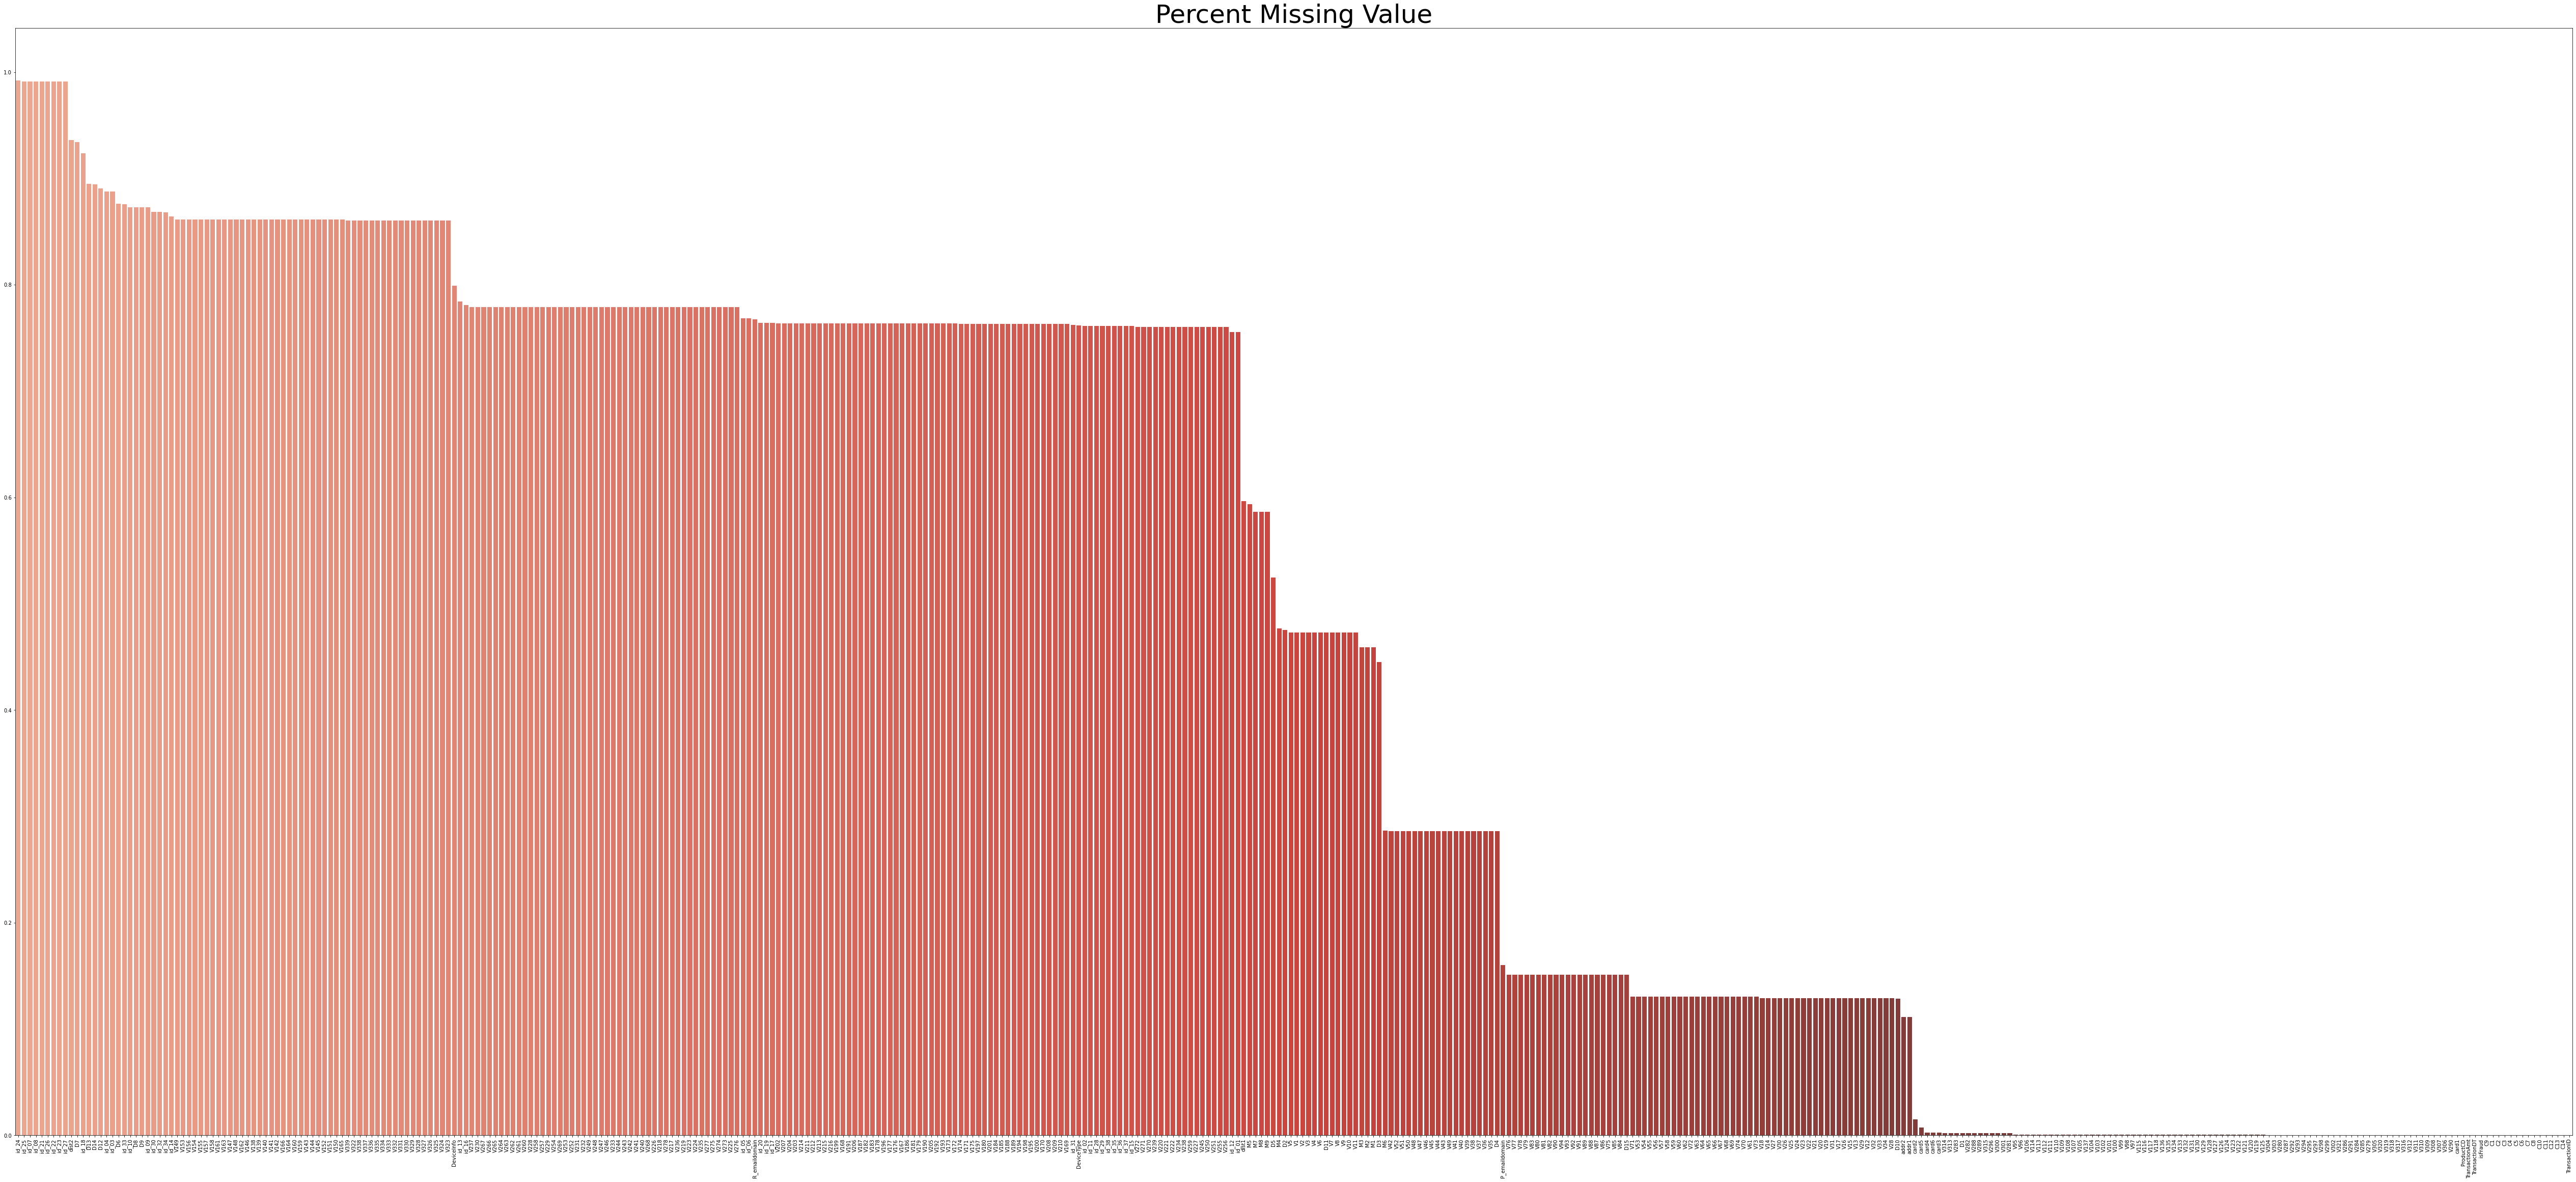

In [23]:
plt.figure(figsize=(90,40))
sns.barplot(y=train.isnull().sum().sort_values(ascending=False)/len(train),
            x=train.isnull().sum().sort_values(ascending=False).index,
            palette="Reds_d")
plt.title("Percent Missing Value",size=50)
plt.xticks(rotation=90)

In [25]:
columns_def=pd.DataFrame({"na_count":train.isnull().sum().sort_values(ascending=False)})
columns_def["per"]=columns_def["na_count"]/len(train)
range=[0.05, 0.10 ,0.15, 0.25, 0.40, 0.60, 0.75]
for i in range: 
    print (columns_def[columns_def["per"]<i].shape[0]/train.shape[1])

0.25806451612903225
0.25806451612903225
0.3686635944700461
0.41935483870967744
0.46543778801843316
0.5207373271889401
0.5207373271889401


In [26]:
columns_def


,na_count,per
id_24,585793,0.991962
id_25,585408,0.991310
id_07,585385,0.991271
id_08,585385,0.991271
id_21,585381,0.991264
...,...,...
C11,0,0.000000
C12,0,0.000000
C13,0,0.000000
C14,0,0.000000


In [29]:
limit=0.15

#Select final columns
columns_final=columns_def[columns_def["per"]<limit].index 

train_full_df=train[train.columns.intersection(columns_final)]

In [30]:
train_full_df.shape

(590540, 160)

###Dealing with Categorical Variables

In [31]:
#Show categorical variables
train_full_df[train_full_df.select_dtypes(include=['object']).columns]

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit
...,...,...,...
590535,W,visa,debit
590536,W,mastercard,debit
590537,W,mastercard,debit
590538,W,mastercard,debit


#### Cleaning up categorical data and removing NA values

In [32]:
#Converts infinite values to NA
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)
clean_inf_nan(train_full_df)
### step2: Replace all NaN with 0
train_full_df.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [33]:
#Using Label Encoder to convert categorical data to numerical Data
for col in train_full_df.columns:
    if train_full_df[col].dtype == "object":
        le = LabelEncoder()
        le.fit(list(train_full_df[col].astype(str).values))
        train_full_df[col] = le.transform(list(train_full_df[col].astype(str).values))
   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Show categorical variables
train_full_df[train_full_df.select_dtypes(include=['object']).columns]

In [36]:
#Confirming percentages of Labels
len(train_full_df[train_full_df["isFraud"]==1])/len(train_full_df)*100

3.4990009144173126

In [38]:
#Creating data final data arrays
x_full_df=train_full_df.drop(["isFraud"],axis=1)
y_full_df=train_full_df["isFraud"]
X_train,X_test,y_train,y_test=train_test_split(x_full_df,y_full_df,test_size=0.8)

## **Now Enter our model**
I will use both Random Forest and AdaptiveBoost to compare the performance of both models
#### **Random Forest Classifier**


In [41]:
#Using Simple Random Forest
%%time
rf = RandomForestClassifier(
    max_depth=45, max_features=30, n_estimators=500, n_jobs=-1, min_samples_leaf=200
)
model_1 = rf.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

#Performance
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred_1))

Accuracy:  0.9681626138788227
CPU times: user 9min 40s, sys: 2.38 s, total: 9min 42s
Wall time: 5min 1s


### Confustion matrix

In [42]:
pd.crosstab(
    y_test,
    y_pred_1,
    rownames=["True"],
    colnames=["Predicted"],
    margins=True,
)

Predicted,0,1,All
True,,,
0,455608,295,455903
1,14746,1783,16529
All,470354,2078,472432


### Adaptive Boosting

In [43]:
AdaModel = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
model_2 = AdaModel.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred_2))


Accuracy:  0.969578690689877


### Confusion matrix

In [44]:
pd.crosstab(
    y_test,
    y_pred_2,
    rownames=["True"],
    colnames=["Predicted"],
    margins=True,
)

Predicted,0,1,All
True,,,
0,455090,813,455903
1,13559,2970,16529
All,468649,3783,472432


In [58]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
recall_score(y_test,y_pred_2)

0.17968419142113862

###Generating final Submission File to Kaggle

In [45]:
sub = pd.read_csv("sample_submission.csv")
sub

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


In [53]:
y_pred_2

array([0, 0, 0, ..., 0, 0, 0])